# Classificação de sequencias

In [64]:
import os, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import torch
from torch import nn, optim
from torchtext import data
from torchtext import datasets
import torch.nn.functional as F

SEED = 1234
torch.manual_seed(SEED)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## IMDb Reviews


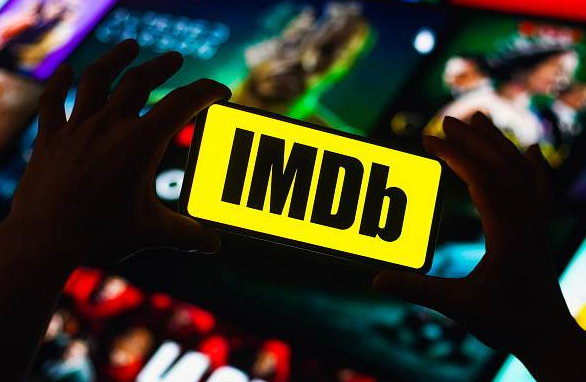


## Torchtext

Similar ao torchvision para imagens, o pacote torchtext facilita o trabalho com texto, oferecendo ferramentas aproveitáveis para outros dados sequenciais.

Um dos seus principais elementos é o `Field`, objeto que carrega informações de como os dados devem ser processados. 

No nosso caso temos dois dados:
* Texto: Uma sequência de caracteres que será dividida em **tokens**. Armazenaremos também os tamanhos das frases pois mais a frente veremos como trabalhar com sequências de tamanhos variáveis

  * Ex: "Bom dia Brasil!" $\rightarrow$ `["bom", "dia", "brasil", "!"]`

```python
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
```

* Label: Categorias descritas como "pos" e "neg". Essas serão transformadas para valores numéricos {neg: 0, pos: 1}

```python
LABEL = data.LabelField(dtype = torch.long)
```



In [38]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.long)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [27]:
for sample in valid_data:
  
  print(vars(sample))
  
  texto = sample.text
  label = sample.label

  break

{'text': ['*', '*', '*', '1/2', 'Out', 'of', '*', '*', '*', '*', '*', 'While', 'I', 'am', 'not', 'concerned', 'with', 'the', 'fact', 'that', 'this', 'is', 'an', 'English', 'dubbed', 'version', 'as', 'some', 'reviewers', 'have', 'mentioned', ',', 'it', 'should', 'be', 'noted', ',', 'as', 'it', 'seems', 'to', 'reside', 'in', 'many', 'Quebecois', 'native', 'hearts', '.', 'However', ',', 'this', 'was', 'a', 'movie', 'as', 'a', 'child', 'that', 'I', 'was', 'a', 'fervent', 'admirer', 'of', ';', 'keeping', 'in', 'mind', 'now', 'that', 'it', 'was', 'made', 'for', 'children', ',', 'I', 'rate', 'it', 'on', 'a', 'relative', 'basis', '.', 'The', 'story', 'is', 'of', 'children', 'on', 'winter', 'break', 'building', 'an', 'awesome', 'snow', 'fort', ',', 'and', 'jostling', "back-'n", '-', 'forth', 'for', 'control', 'with', 'weapons', 'such', 'as', 'snowballs', 'and', 'other', 'concoctions', ',', 'as', 'idle', 'hands', 'and', 'free', 'time', 'equal', 'winter', 'break', 'lessons', '.', 'If', 'I', 'had'

## Representação do Dado


### Vocabulário

Uma pergunta que pode ter passado na sua cabeça: como alimentamos uma rede neural com palavras de um texto?

Para transformar palavras em dados numéricos, a solução mais simples é mapeá-las em um dicionário contendo o vocabulário completo do conjunto. 

<img src="https://static.packt-cdn.com/products/9781786465825/graphics/B05525_03_01.jpg" width="500">

Podemos fazer isso chamando a função **```build_vocab```** nos nossos fields. Como datasets de texto podem chegar a centenas de milhares de palavras, é importante definir um limite superior para o número de palavras mapeadas pelo dicionário. No código a seguir, esse limite é definido como ```MAX_VOCAB_SIZE = 25000```

Atenção também para o parâmetro ```vectors = "glove.6B.100d"```. O GloVe (Global Vectors) é um método de representação de palavras que explicaremos em maiores detalhes mais a frente. A princípio basta saber que o modelo "glove.**6B**.**100d**" foi treinado em **6 bilhões** de tokens e gera uma representação latente de dimensionalidade  **d = 100**

In [39]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [31]:
print('Tamanho do vocabulario', len(TEXT.vocab),'\n')
print(TEXT.vocab.itos[:10],'\n', LABEL.vocab.stoi, '\n')
TEXT.vocab.freqs.most_common(20)

Tamanho do vocabulario 25002 

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is'] 
 defaultdict(<function _default_unk_index at 0x7f600b9fb510>, {'neg': 0, 'pos': 1}) 



[('the', 200865),
 (',', 191703),
 ('.', 165298),
 ('a', 108905),
 ('and', 108592),
 ('of', 100075),
 ('to', 93043),
 ('is', 76135),
 ('in', 60900),
 ('I', 54283),
 ('it', 53413),
 ('that', 48852),
 ('"', 44066),
 ("'s", 43361),
 ('this', 42376),
 ('-', 36805),
 ('/><br', 35464),
 ('was', 34877),
 ('as', 30278),
 ('movie', 29887)]

### Embedding Layer

Documentação Pytorch: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding

Camadas de embedding são treinadas para mapear um ínidice numérico para um vetor denso de maior carga semântica.

Acabamos de ver a representação de palaras como ínidices de um vocabulário fixo. Apesar do índice informar a qual palavra estamos nos referindo, ele não incorpora nenhuma informação semântica sobre a palavra. O treinamento de embeddings para dados textuais tem como objetivo projetar esses índices em um espaço onde palavras semanticamente similares estejam próximas.

![](https://drive.google.com/uc?export=view&id=1pliMSOcjjOZAiR26ycowSeUJsj5cy9W_)

No Pytorch, a instância dessa classe recebe como parâmetro ```(vocab_size, embedding_size, padding_idx)```
* ```vocab_size```: Tamanho do vocabulário. Note que **não** se trata da dimensionalidade da entrada.
* ```embedding_size```: Dimensionalidade da dimensão latente. Caso haja o aproveitamento de embeddings pré treinadas deve-se definir a dimensionalidade da camada em função dos pesos que serão importados (ex: glove.6b.100d, ```embedding_size=100```).


In [40]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################


  def forward(self, X):
    vectors = self.embedding(X)


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
)


## BucketIterator
Essa classe do Torchtext funciona de forma análoga ao DataLoader do PyTorch,  porém leva em consideração a construção de **batches com sequências de comprimento variável**. Internamente ele agrega sequências de comprimento similar, **minimizando a quantidade de padding necessária**. 

Além disso, os dados já saem preparados para serem empacotados pela função ```pack_padded_sequence``` ordenados por comprimento de sequência e informando o comprimento real de cada amostra (sem padding).

> Exemplo: Para compor um tensor com 5 amostras de frases com tamanhos variáveis, a segunda dimensão é definida pela frase de maior comprimento. Amostras menores são complementadas com tokens nulos (`<pad>`). 

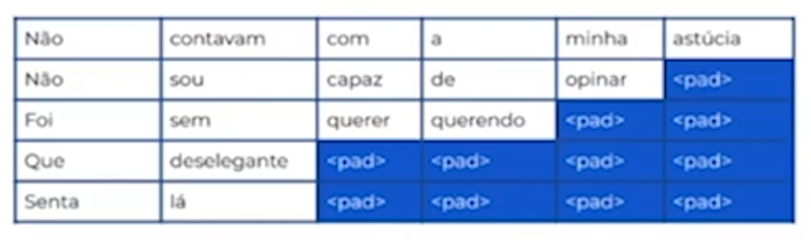

Documentação: https://torchtext.readthedocs.io/en/latest/data.html?highlight=BucketIterator#torchtext.data.BucketIterator


In [40]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [10]:
for sample in valid_iterator:

  texto, tamanho = sample.text
  label = sample.label
  
  print(f'Texto: {texto.shape}, Tamanho: {tamanho.shape}, Label: {label.shape} \n', )

  print(tamanho)

  break

Texto: torch.Size([48, 64]), Tamanho: torch.Size([64]), Label: torch.Size([64]) 

tensor([48, 48, 48, 48, 48, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46,
        45, 45, 45, 45, 44, 44, 44, 44, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 41, 40, 40, 39, 39, 38, 37, 37, 36, 35, 35, 35, 35, 34, 34,
        34, 33, 31, 27, 26, 26, 24, 21, 20, 14], device='cuda:0')


## Padding and Packing (Preenchendo e empacotando)

O pacote de funções de rnn, ```nn.utils.rnn```, oferece meios de processar batches contendo sequências de tamanho variável. Isso é realizado através do **padding** da sequência (ex: preenchimento com zeros),  de modo que elas aparentem ter igual comprimento, porém internamente as posições preenchidas não são processadas pela RNN.

*  Vamos lembrar do nosso batch de frases com tamanhos variáveis:

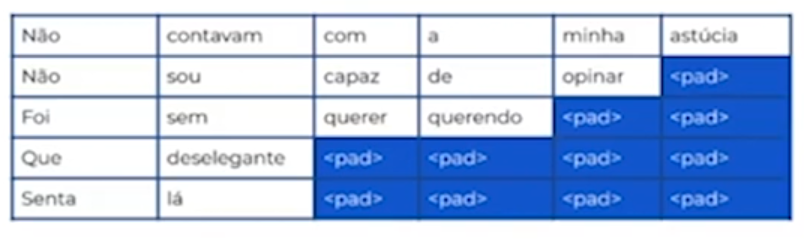

*  O empacotamento precisa receber os dados em ordem decrescente de comprimento, e internamente são criados "mini batches" com o seu batch. Dessa forma, apenas os timesteps que contém informação relevante sobre o dado são apresentadas à rede. Igualmente, somente esses timesteps impactam no backpropagation.

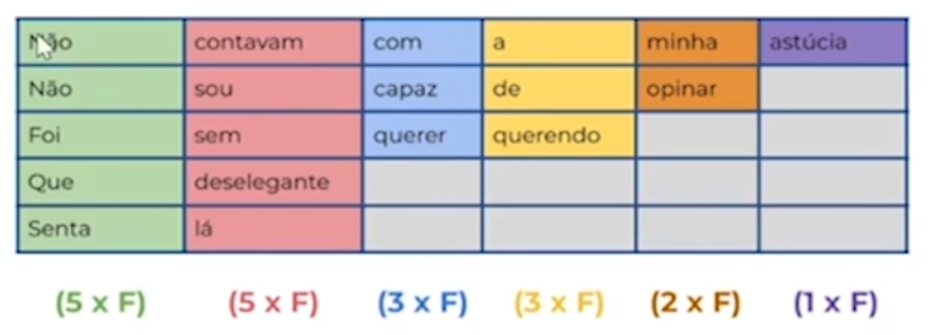


Para isso basta realizar o padding das suas sequências, **preservando os comprimetos originais** em outra variável. Na prática, o forward recebe mais um parâmetro, aqui chamamos de **```tamanhos```**, referente ao comprimento de cada amostra dentro do batch **```X```**, ordenado de forma descrescente.

Tendo em mãos (1) o batch de sequências preenchidas e ordenadas, e (2) o comprimento original de cada amostra, basta realizar as seguintes operações no forward da rede:

```python
## Empacote a sequência antes de alimentar a unidade recorrente
packed_input = nn.utils.rnn.pack_padded_sequence(X, tamanhos)

## Forward recorrente
packed_output, hidden = self.rnn(packed_input, hidden )

## Desempacote a sequência para continuar o fluxo na rede.
output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
```

In [53]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################

    # Camada recorrente
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(tam_embedding, hidden_size)


  def forward(self, X, tamanhos):
    print('X:', X.size(), '\n')
    print('tamanhos', tamanhos, '\n')
    vectors = self.embedding(X)
    print('Vectors:', vectors.size(), '\n')

    hidden = torch.randn(1, X.size(1), self.hidden_size)

    ## Empacote a sequência antes de alimentar a unidade recorrente
    packed_input = nn.utils.rnn.pack_padded_sequence(vectors, tamanhos)
    print('Packed input:', packed_input.batch_sizes, '\n')
    
    ## Forward recorrente
    packed_output, hidden = self.rnn(packed_input, hidden )
    print('Packed output:', packed_output.batch_sizes, '\n')

    ## Desempacote a sequência para continuar o fluxo na rede.
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    print('output:', output.size(), '\n')

    return output


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

hidden_size = 256

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 256)
)


In [54]:
for sample in valid_iterator:
  texto, tamanhos = sample.text
  label = sample.label

  saida = model(texto, tamanhos)
  break

X: torch.Size([48, 64]) 

tamanhos tensor([48, 48, 48, 48, 48, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46,
        45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 44, 43, 43, 43, 42, 41, 41, 41,
        41, 40, 40, 39, 39, 38, 38, 38, 37, 36, 35, 35, 34, 34, 33, 32, 32, 31,
        31, 29, 28, 27, 26, 22, 21, 18, 14, 14]) 

Vectors: torch.Size([48, 64, 100]) 

Packed input: tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 62, 62, 62, 62,
        61, 61, 61, 60, 59, 59, 59, 59, 58, 57, 56, 55, 55, 53, 51, 50, 48, 46,
        45, 44, 41, 39, 37, 33, 32, 29, 21, 18,  9,  5]) 

Packed output: tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 62, 62, 62, 62,
        61, 61, 61, 60, 59, 59, 59, 59, 58, 57, 56, 55, 55, 53, 51, 50, 48, 46,
        45, 44, 41, 39, 37, 33, 32, 29, 21, 18,  9,  5]) 

output: torch.Size([48, 64, 256]) 



## Classificando Sequências


In [82]:
class RNN(nn.Module):
  
  def __init__(self, tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size, output_size):
    super(RNN, self).__init__()

    # Inicializaremos a camada de embedding
    self.embedding = nn.Embedding(tam_vocab, tam_embedding)
    self.embedding.weight.data.copy_(embed_vectors)
    self.embedding.weight.data[ind_unk] = torch.zeros(tam_embedding)
    self.embedding.weight.data[ind_pad] = torch.zeros(tam_embedding)
    #######################################

    self.hidden_size = hidden_size
    self.rnn = nn.GRU(tam_embedding, hidden_size)
    self.linear = nn.Linear(hidden_size, output_size)


  def forward(self, X, tamanhos):
    vectors = self.embedding(X)

    hidden = torch.zeros(1, X.size(1), self.hidden_size).to(device)

    packed_input = nn.utils.rnn.pack_padded_sequence(vectors, tamanhos)
    packed_output, hidden = self.rnn(packed_input, hidden )
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    
    # print('output:', output.size())
    output = F.adaptive_max_pool1d(output.permute(1,2,0), 1)
    # print('output pool:', output.size())
    output = self.linear(output.squeeze())
    # print('output linear:', output.size())

    return output


tam_vocab = len(TEXT.vocab)
tam_embedding = 100 # glove 100d
embed_vectors = TEXT.vocab.vectors
ind_pad = TEXT.vocab.stoi[TEXT.pad_token]
ind_unk = TEXT.vocab.stoi[TEXT.unk_token]

hidden_size = 256
output_size = 2

model = RNN(tam_vocab, tam_embedding, embed_vectors, 
               ind_unk, ind_pad, hidden_size, output_size)

model = model.to(device)

print(model)

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 256)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)


In [34]:
for sample in valid_iterator:
  texto, tamanhos = sample.text
  label = sample.label

  saida = model(texto, tamanhos.cpu())
  break

output: torch.Size([48, 64, 256])
output pool: torch.Size([64, 256, 1])
output linear: torch.Size([64, 2])


### Loss e Otimizador

In [83]:
criterio = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

In [84]:
def forward(iterator, num_samples, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for k, sample in enumerate(iterator):
      
    texto, tamanhos = sample.text
    rotulo = sample.label

    saida = model(texto, tamanhos.cpu())

    loss = criterio(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += (pred.cpu().data == rotulo.cpu().data).sum()
    
    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(num_samples)
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [85]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

for epoca in range(25):
  loss, acuracia = forward(train_iterator, len(train_data), 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

  loss, acuracia = forward(valid_iterator, len(valid_data), 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)



 ***************Treino***************
Epoca: 0, Loss: 0.6810 +/- 0.0121, Acurácia: 0.5888

 ***************Teste***************
Epoca: 0, Loss: 0.6581 +/- 0.0157, Acurácia: 0.6287

 ***************Treino***************
Epoca: 1, Loss: 0.5725 +/- 0.0601, Acurácia: 0.7043

 ***************Teste***************
Epoca: 1, Loss: 0.5196 +/- 0.0609, Acurácia: 0.7489

 ***************Treino***************
Epoca: 2, Loss: 0.4872 +/- 0.0590, Acurácia: 0.7723

 ***************Teste***************
Epoca: 2, Loss: 0.4728 +/- 0.0524, Acurácia: 0.7811

 ***************Treino***************
Epoca: 3, Loss: 0.4490 +/- 0.0684, Acurácia: 0.7944

 ***************Teste***************
Epoca: 3, Loss: 0.4318 +/- 0.0657, Acurácia: 0.8008

 ***************Treino***************
Epoca: 4, Loss: 0.4180 +/- 0.0682, Acurácia: 0.8092

 ***************Teste***************
Epoca: 4, Loss: 0.4110 +/- 0.0693, Acurácia: 0.8145

 ***************Treino***************
Epoca: 5, Loss: 0.3824 +/- 0.0693, Acurácia: 0.8287

 **

In [118]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    model.eval()
    tokenized = [str(tok) for tok in nlp.tokenizer(sentence)]
    print(tokenized)

    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    print(indexed)
    
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    
    prediction = model(tensor, length_tensor)
    
    return F.softmax(prediction, dim=-1).cpu().data

['This', 'movie', 'had', 'an', 'interesting', 'enough', 'plot', 'about', 'clones', 'and', 'organ', 'usage', ',', 'but', 'it', 'fails', 'as', 'the', 'lead', 'actor', 'is', 'so', 'annoying', 'and', 'whiny', 'you', 'want', 'him', 'dead', '.', 'Not', 'that', 'anyone', 'else', 'is', 'very', 'good', 'in', 'it', 'either', ',', 'but', 'when', 'you', 'hate', 'the', 'character', 'that', 'is', 'supposed', 'to', 'be', 'garnering', 'your', 'sympathy', 'the', 'movie', 'just', 'fails', 'to', 'work', '.', 'Funny', 'enough', ',', 'it', 'looks', 'like', 'a', 'movie', 'is', 'coming', 'out', 'in', 'the', 'near', 'future', 'that', 'has', 'a', 'plot', 'that', 'mirrors', 'this', 'one', 'with', 'more', 'action', 'and', 'a', 'better', 'cast', ',', 'still', 'though', 'I', 'wo', "n't", 'be', 'able', 'to', 'think', 'of', 'anything', 'else', ',', 'but', 'this', 'film', 'if', 'I', 'were', 'to', 'watch', 'it', '.', 'This', 'movie', 'has', 'a', 'super', 'dumb', 'clone', 'that', 'is', 'somehow', 'smart', 'enough', 'to

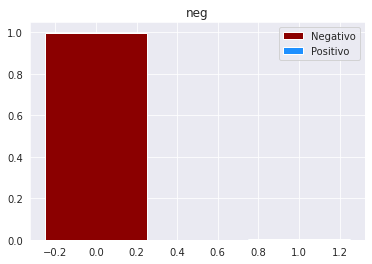

['Physical', 'Evidence', 'is', 'one', 'of', 'those', 'films', 'that', 'you', 'want', 'to', 'like', 'but', 'really', 'should', 'be', 'a', 'lot', 'better', 'than', 'it', 'actually', 'is', '.', 'Developed', 'as', 'a', 'sequel', 'to', 'Jagged', 'Edge', 'for', 'Glenn', 'Close', 'and', 'Robert', 'Loggia', ',', 'it', 'gives', 'the', 'impression', 'that', 'all', 'involved', 'only', 'made', 'it', 'while', 'they', 'were', 'waiting', 'for', 'something', 'better', 'to', 'come', 'along', '.', 'The', 'premise', 'is', 'perfectly', 'serviceable', ',', 'it', "'s", 'mostly', 'technically', 'efficient', 'if', 'horribly', 'uninspired', 'with', 'even', 'Henry', 'Mancini', "'s", 'musacky', 'score', 'surprisingly', 'pleasant', ',', 'but', 'you', 'ca', "n't", 'help', 'feeling', 'that', 'things', 'would', 'have', 'turned', 'out', 'better', 'if', 'one', 'of', 'the', 'leads', 'had', 'turned', 'out', 'to', 'be', 'the', 'killer', '(', 'as', 'is', 'rumoured', 'was', 'originally', 'the', 'case', ')', '.', 'As', 'the

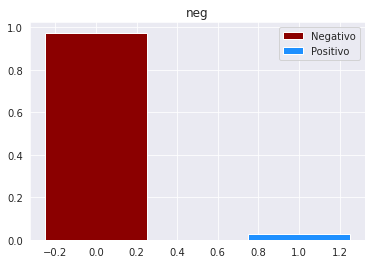

['I', 'must', 'say', 'THIS', 'IS', 'THE', 'BEST', 'MOVIE', 'I', 'HAVE', 'EVER', 'SEEN', '.', 'i', 'know', 'that', 'on', 'this', 'website', 'it', "'s", 'received', 'only', 'negative', 'reviews', ',', 'but', 'for', 'once', 'I', "'d", 'like', 'to', 'be', 'the', 'good', 'person', 'who', 'gives', 'the', 'worlds', 'best', 'movie', 'a', 'good', 'review', '.', 'i', 'find', 'the', 'movie', 'to', 'be', 'extremely', 'funny', ',', 'and', 'it', 'has', 'the', 'perfect', 'mix', 'of', 'everything', '.', 'it', 'makes', 'me', 'feel', 'all', 'sorts', 'of', 'emotions', 'when', 'i', 'watch', 'it', ',', 'and', 'I', 'ca', "n't", 'get', 'enough', 'of', 'it', '.', 'the', 'soundtracks', 'brilliant', '.', 'I', 'LOVE', 'IT', ',', 'i', 'understand', 'why', 'people', 'may', 'not', 'love', 'it', 'as', 'much', 'as', 'I', 'do', ',', 'but', 'I', 'do', "n't", 'understand', 'how', 'people', 'could', 'hate', 'it', '.', 'The', 'movie', 'is', '100', '%', 'brilliance', '.', 'Blurred', 'is', 'amazing', '.', 'i', 'never', 'rea

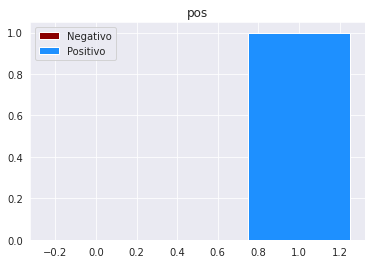

['Great', 'characters', ',', 'great', 'acting', ',', 'great', 'dialogue', ',', 'incredible', 'plot', 'twists', 'in', 'plain', 'language', 'one', 'of', 'the', 'best', 'shows', 'I', "'", 've', 'ever', 'seen', 'in', 'my', 'life', '.', 'Do', 'yourself', 'a', 'favor', 'and', 'watch', 'this', 'show', ',', 'you', 'wo', "n't", 'regret', 'it', '.', 'This', 'show', 're', '-', 'writes', 'the', 'book', 'on', 'Sci', '-', 'Fi', '!']
[1178, 120, 3, 103, 132, 3, 103, 458, 3, 1208, 126, 1284, 10, 1084, 1159, 38, 7, 2, 145, 295, 11, 49, 13197, 146, 123, 10, 83, 133, 4, 496, 716, 5, 2212, 6, 130, 16, 137, 3, 31, 497, 30, 2639, 12, 4, 66, 137, 886, 17, 4531, 2, 301, 29, 2644, 17, 2882, 39]


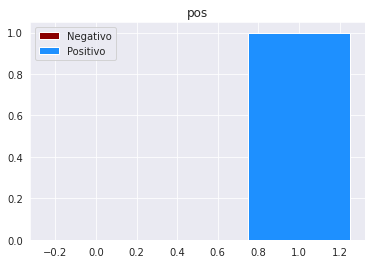

['I', 'have', 'just', 'watched', 'this', '"', 'latest', '"', 'version', 'of', 'Macbeth', 'and', 'was', 'pleasantly', 'surprised', 'with', 'the', 'solid', 'acting', 'and', 'obvious', 'effort', 'that', 'had', 'to', 'turn', 'a', 'low', 'budget', 'historical', 'piece', 'into', 'a', 'fully', 'fledged', 'watchable', 'movie.<br', '/><br', '/>One', 'note', 'however', ',', 'the', 'music', 'was', 'very', 'lame', 'and', 'added', 'nothing', 'to', 'the', 'intensity', 'of', 'the', 'film', 'and', 'sounded', 'like', 'someone', 'with', 'a', 'keyboard', 'and', 'a', 'bunch', 'of', 'samplers', 'as', 'opposed', 'to', 'a', 'full', 'orchestral', 'score', '.', 'I', 'think', 'Paul', 'Farrer', 'needs', 'to', 'get', 'his', 'act', 'together', '!', '!', '!']
[11, 34, 56, 319, 16, 14, 2665, 14, 343, 7, 13338, 6, 19, 3751, 837, 22, 2, 1203, 132, 6, 592, 824, 13, 71, 8, 494, 5, 371, 365, 1428, 449, 93, 5, 1316, 16417, 1959, 855, 18, 1452, 1053, 431, 3, 2, 263, 19, 63, 863, 6, 1363, 195, 8, 2, 3256, 7, 2, 24, 6, 2854,

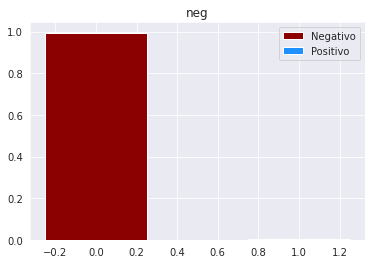

In [122]:
np.random.seed(42)
for i in range(5):
  idx = np.random.choice(len(test_data))
  text = test_data[idx].text 
  pred = predict_sentiment(' '.join(text) )

  plt.bar(0, pred[0], color='darkred', label='Negativo', width=0.5)
  plt.bar(1, pred[1], color='dodgerblue', label='Positivo', width=0.5)
  plt.title(str(test_data[idx].label))
  plt.legend()
  plt.show()